## Домашнее задание. Сверточные сети

Здесь вам предстоит построить и обучить свою первую сверточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') #используйте параметр ограничения роста памяти графического процессора
tf.config.experimental.set_memory_growth(gpus[0], True) 
from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

### Данные

CIFAR10 

60000 RGB изображений размером 32*32*3

10 классов - самолеты, собаки, рыбы и т.п.

Загрузите данные, разделите на тестовую и обучающую выборки. Размер тестовой выборки должен быть 10^4

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 10**4, random_state = 42)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступить к основной работе, стоит убедиться, что загруженно именно то, что требовалось:

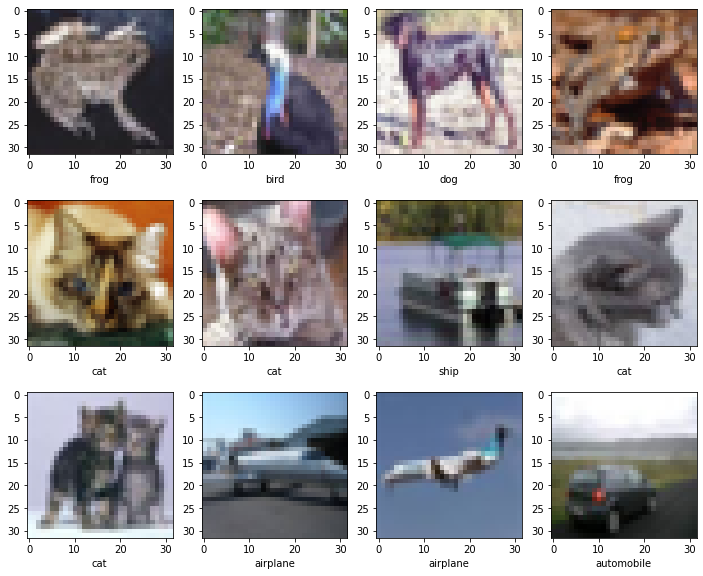

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = [12,10])
for i in range(12):
    plt.subplot(3,4, i+1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) от 0 до 255. Однако лучше себя показывает подход, где
значения входов нейросети распределены недалеко от 0.

Давайте приведем все данные в диапазон [0,1] - просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно:

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, [X_train, X_val, X_test])) <= 1.05
assert 0.0 <= min(map(np.min, [X_train, X_val, X_test])) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
    1. принимает на вход картинки размера 32х32х3;
    2. вытягивает их в вектор (keras.layers.Flatten);
    3. пропускает через 1 или 2 полносвязных слоя;
    4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [7]:
y_train = tf.keras.utils.to_categorical(y_train) #сделаем one-hot-encoding для y_train
y_train.shape

(40000, 10)

In [8]:
y_val = tf.keras.utils.to_categorical(y_val) #сделаем one-hot-encoding для y_val
y_test = tf.keras.utils.to_categorical(y_test) #сделаем one-hot-encoding для y_test

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

hid_size = 512 # зададим размер слоя

model = Sequential(name = 'my_first_model')
model.add(keras.Input(shape = X_train.shape[1:])) #принимает на вход картинки размера 32х32х3
model.add(keras.layers.Flatten()) #вытягивает их в вектор (keras.layers.Flatten)
model.add(keras.layers.Dense(hid_size*2)) #пропускает через 1 полносвязный слой
model.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model.add(keras.layers.Dense(hid_size*4)) #пропускает через 2 полносвязный слой
model.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model.add(keras.layers.Dense(10, activation = 'softmax')) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [10]:
model.summary()

Model: "my_first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 5,266,442
Trainable params: 5,266,442
Non-trainable params: 0
__________________________________________

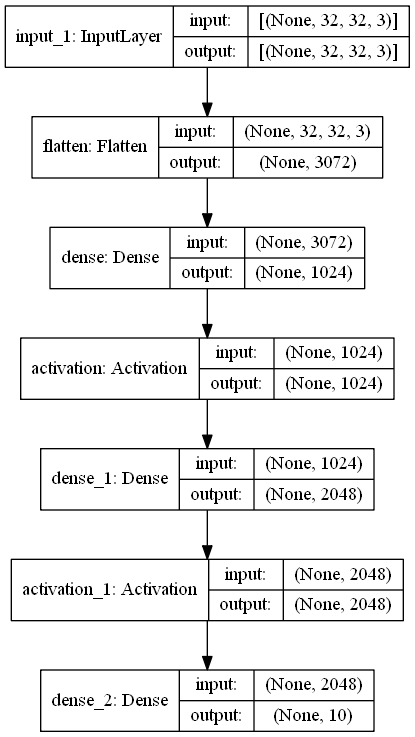

In [11]:
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True) #show_shapes=True - тогда покажет, что на вход и на выход

In [12]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20,10)
assert np.allclose(dummy_pred.sum(-1),1)
print('Успех')

Успех


## Обучение сети

Задание 1.1 (обязательно) Будем минимизировать многоклассовую кросс-энтропию с помощью sgd. Вам нужно получить сеть, которая достигнет не менее 45% accuracy на тестовых данных.

Важно: поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (sparse_categorical_crossentropy и sparse_categorical_accuracy), либо конвертировать метки в one-hot формат

Полезные советы

model.compile позволяет указать, какие метрики вы хотите вычислить
В model.fit можно передать валидационную выборку (validation_data = [X_val, y_val]), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в tensorboard или wandb. Важно: логи tensorboard не получится без боли посмотреть через colab.
Workaround: скачать логи и запустить tensorboard локально или помучиться с этим.

По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе fit.
Еще у Кераса есть много полезных callback-ов, которые можно попробовать. Например автоматическая остановка или подбор скорости обучения.

In [13]:
# y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val)) # уже делала  one-hot в ячейке выше

In [14]:
callback = [keras.callbacks.EarlyStopping(monitor='val_loss',  
                                                   patience=3),#прекращает обучения, когда параметр monitor перестает улучшаться.
           keras.callbacks.TensorBoard(log_dir='./logs',
                                       profile_batch=5)] #записывает логи

In [15]:
# скомпилируем модель
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

In [16]:
# запускаем обучение
model.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2, 
          callbacks=callback,
          validation_data = [X_val, y_val])

Epoch 1/10
1600/1600 [==============================] - 23s 14ms/step - loss: 1.9779 - accuracy: 0.2843 - val_loss: 1.7422 - val_accuracy: 0.3823
Epoch 2/10
1600/1600 [==============================] - 18s 11ms/step - loss: 1.6945 - accuracy: 0.4004 - val_loss: 1.6298 - val_accuracy: 0.4178
Epoch 3/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.5951 - accuracy: 0.4307 - val_loss: 1.5847 - val_accuracy: 0.4396
Epoch 4/10
1600/1600 [==============================] - 17s 10ms/step - loss: 1.5358 - accuracy: 0.4553 - val_loss: 1.5281 - val_accuracy: 0.4619
Epoch 5/10
1600/1600 [==============================] - 17s 11ms/step - loss: 1.4888 - accuracy: 0.4743 - val_loss: 1.5129 - val_accuracy: 0.4594
Epoch 6/10
1600/1600 [==============================] - 17s 11ms/step - loss: 1.4331 - accuracy: 0.4991 - val_loss: 1.4860 - val_accuracy: 0.4647
Epoch 7/10
1600/1600 [==============================] - 17s 11ms/step - loss: 1.3883 - accuracy: 0.5069 - val_loss: 1.4807 -

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [21]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
# импользование model.evaluate может давать различия в accuracy, поэтому поступим иначе:

In [22]:
#Выведем значение accuracy на тесте
def predict_classes(model, X):
    """
    Предскажем значения классов для каждого y, переведем в one-hot
    """
    predicted = np.argmax(model.predict(X), axis=-1)
    predicted = keras.utils.to_categorical(predicted)
    return predicted

test_scores = accuracy_score(y_test, predict_classes(model, X_test))
print("Test accuracy:", test_scores)
assert test_scores > 0.45, "Not good enough. Back to the drawing board :)"
print("Not bad")

Test accuracy: 0.5018
Not bad


In [19]:
# Значение на тесте 0.496 - идем дальше. 

## Карманная сверточная сеть

Задание 1.2. (обязательно) Реализуйте небольшую сверточную сеть. Совсем небольшую:
    1. Входной слой
    2. Свертка 3х3 с 10-ю фильтрами
    3. Нелинейность на ваш вкус
    4. Max-pooling 2х2
    5. Вытягиваем оставшееся в вектор (Flatten)
    6. Полносвязный слой на 100 нейронов
    7. Нелинейность на ваш вкус
    8. Выходной полносвязный слой с softmax
    
Обучите ее также, как и предыдущую сеть. Если все хорошо, у вас получится accuracy не меньше 50%.

In [19]:
hid_size = 100 # зададим размер слоя

model2 = Sequential(name = "my_second_model")
model2.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model2.add(keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3))) #Свертка 3х3 с 10-ю фильтрами
model2.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model2.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model2.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model2.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model2.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [20]:
model2.summary()

Model: "my_second_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 10)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               225100    
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)            

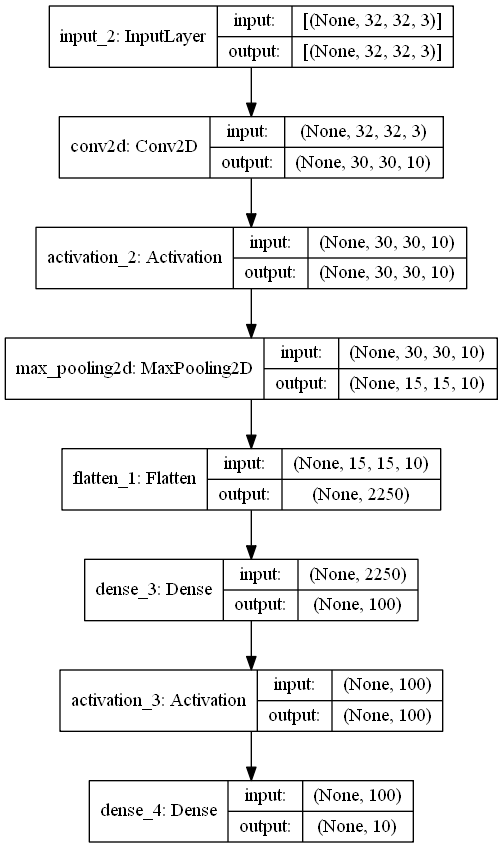

In [21]:
keras.utils.plot_model(model2, "my_second_model.png", show_shapes=True) #show_shapes=True - тогда покажет, что на вход и на выход

In [22]:
# скомпилируем модель
model2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# запускаем обучение
model2.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2, 
          callbacks=callback,
          validation_data = [X_val, y_val])

Epoch 1/10
1600/1600 [==============================] - 20s 10ms/step - loss: 2.1057 - accuracy: 0.2290 - val_loss: 1.7967 - val_accuracy: 0.3716
Epoch 2/10
1600/1600 [==============================] - 14s 9ms/step - loss: 1.7547 - accuracy: 0.3809 - val_loss: 1.6206 - val_accuracy: 0.4234
Epoch 3/10
1600/1600 [==============================] - 17s 11ms/step - loss: 1.5657 - accuracy: 0.4442 - val_loss: 1.4629 - val_accuracy: 0.4820
Epoch 4/10
1600/1600 [==============================] - 15s 10ms/step - loss: 1.4108 - accuracy: 0.5051 - val_loss: 1.3641 - val_accuracy: 0.5165
Epoch 5/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.2892 - accuracy: 0.5493 - val_loss: 1.2975 - val_accuracy: 0.5452
Epoch 6/10
1600/1600 [==============================] - 14s 8ms/step - loss: 1.2281 - accuracy: 0.5687 - val_loss: 1.2790 - val_accuracy: 0.5465
Epoch 7/10
1600/1600 [==============================] - 14s 9ms/step - loss: 1.1646 - accuracy: 0.5932 - val_loss: 1.2616 - va

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству

In [24]:
#Выведем значение accuracy на тесте
test_scores = accuracy_score(y_test, predict_classes(model2, X_test))
print("Test accuracy:", test_scores)
assert test_scores > 0.50, "Not good enough. Back to the drawing board :)"
print("Not bad")

Test accuracy: 0.5729
Not bad


## Учимся учить
А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать экспериментальный стенд — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью keras.callbacks — TensorBoard или History.

Будьте морально готовы, что на обучение уйдёт много времени. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

Задание 1.3 (опционально) 

Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [25]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self): #tqdm_notebook устарел, заменила
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def predict_classes(models, X): #написала новый метод в классе, чтобы работал метод evaluate
        """
        Предскажем значения классов для каждого y, переведем в one-hot
        """
        predicted = np.argmax(models.predict(X), axis=-1)
        predicted = keras.utils.to_categorical(predicted)
        return predicted      
        
    def evaluate(self, X, y, models, metric):
        for model_name, models, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, predict_classes(models, X)))) #не работает model.predict_classes, поэтому переписала код, чтобы работало

In [27]:
#!rm -rf ./logs

In [26]:
optimizers = {
    'adam': 'adam',
    'sgd': 'sgd',
    'RMSprop': 'RMSprop'
} 
#momentum нет: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers, добавила RMSprop - по умолчанию там используется простой импульс

In [27]:
evaluator = Evaluator(models = model2, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test,model2,accuracy_score)


Final score of single_model_adam is 0.54
Final score of single_model_sgd is 0.5796
Final score of single_model_RMSprop is 0.5711


Прокомментируйте полученные результаты.

Наилучший accuracy дала оптимизация при помощи sgd, я немного удивлена результатом (ставила на adam)). 
Batch_size в модели = 20, возможно при нем градиенты не колбасит от батча к батчу и поэтому sgd работает неплохо. 
Но это мое предположение, других мыслей просто нет...

Задание 1.4 (опционально) Добавьте нормализацию по батчу (BatchNormalization) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [28]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# # Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# # ...

In [29]:
# зададим две нормализации по батчу
hid_size = 100 # зададим размер слоя

model3 = Sequential(name = "my_third_model")
model3.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model3.add(keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3))) #Свертка 3х3 с 10-ю фильтрами
model3.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model3.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model3.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model3.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model3.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model3.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model3.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model3.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [30]:
# скомпилируем модель
model3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# запускаем обучение
model3.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2, 
          callbacks=callback,
          validation_data = [X_val, y_val])

Epoch 1/10
1600/1600 [==============================] - 21s 12ms/step - loss: 1.8110 - accuracy: 0.3583 - val_loss: 1.6858 - val_accuracy: 0.4111
Epoch 2/10
1600/1600 [==============================] - 20s 12ms/step - loss: 1.3588 - accuracy: 0.5213 - val_loss: 1.3745 - val_accuracy: 0.5099
Epoch 3/10
1600/1600 [==============================] - 18s 11ms/step - loss: 1.2145 - accuracy: 0.5737 - val_loss: 1.2444 - val_accuracy: 0.5521
Epoch 4/10
1600/1600 [==============================] - 18s 11ms/step - loss: 1.1230 - accuracy: 0.6078 - val_loss: 1.2821 - val_accuracy: 0.5514
Epoch 5/10
1600/1600 [==============================] - 18s 12ms/step - loss: 1.0443 - accuracy: 0.6336 - val_loss: 1.1500 - val_accuracy: 0.5941
Epoch 6/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.9954 - accuracy: 0.6549 - val_loss: 1.2360 - val_accuracy: 0.5738
Epoch 7/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.9296 - accuracy: 0.6775 - val_loss: 1.2327 -

In [32]:
#Выведем значение accuracy на тесте
test_scores = accuracy_score(y_test, predict_classes(model3, X_test))
print("Test accuracy:", test_scores)

Test accuracy: 0.5878


In [33]:
# одна нормализация  по батчу (только после свертки)
hid_size = 100 # зададим размер слоя

model4 = Sequential(name = "my_four_model")
model4.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model4.add(keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3))) #Свертка 3х3 с 10-ю фильтрами
model4.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model4.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model4.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model4.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model4.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model4.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model4.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [34]:
# скомпилируем модель
model4.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# запускаем обучение
model4.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2, 
          callbacks=callback,
          validation_data = [X_val, y_val])

Epoch 1/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.8023 - accuracy: 0.3513 - val_loss: 1.9603 - val_accuracy: 0.3730
Epoch 2/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.3561 - accuracy: 0.5177 - val_loss: 1.4147 - val_accuracy: 0.4919
Epoch 3/10
1600/1600 [==============================] - 14s 9ms/step - loss: 1.2315 - accuracy: 0.5670 - val_loss: 1.4068 - val_accuracy: 0.5123
Epoch 4/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.1376 - accuracy: 0.5964 - val_loss: 1.3813 - val_accuracy: 0.5344
Epoch 5/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.0465 - accuracy: 0.6325 - val_loss: 1.2060 - val_accuracy: 0.5779
Epoch 6/10
1600/1600 [==============================] - 15s 9ms/step - loss: 0.9786 - accuracy: 0.6533 - val_loss: 1.2382 - val_accuracy: 0.5756
Epoch 7/10
1600/1600 [==============================] - 15s 9ms/step - loss: 0.8960 - accuracy: 0.6888 - val_loss: 1.3066 - val_a

In [36]:
#Выведем значение accuracy на тесте
test_scores = accuracy_score(y_test, predict_classes(model4, X_test))
print("Test accuracy:", test_scores)

Test accuracy: 0.5766


Прокомментируйте полученные результаты.

Использование нормализации по батчу только после свертки позволило сократить скорость обучения, так как т.к. все значения получаются одного порядка.
Но это может немножко негативно сказаться на качестве. Accuracy аналогичной модели model2 без BatchNormalization практически сопоставима (0.5729) с при ее использованием BN только после свертки (0.5766). Применение двух BN повысило accuracy до 0.5878

Задание 1.5 (опционально) Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху). Найдите такое значение, при котором модель быстрее достигает точности 55%. Hint: используйте early stopping callback.

In [39]:
# проверим как отработает EarlyStopping на одной модели
callback2 = [keras.callbacks.EarlyStopping(monitor='accuracy', baseline=0.55)] #прекращает обучения, когда параметр monitor перестает улучшаться.
hid_size = 100 # зададим размер слоя
model5 = Sequential()
model5.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model5.add(keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3))) #Свертка 3х3 с 10-ю фильтрами
model5.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model5.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model5.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model5.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model5.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model5.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model5.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
history = model5.fit(X_train, 
          y_train,
          batch_size=15, 
          epochs=10,
          validation_split=0.2,
          callbacks = callback2,
          validation_data = [X_val, y_val])
len(history.history['accuracy'])

Epoch 1/10
2134/2134 [==============================] - 26s 12ms/step - loss: 1.7489 - accuracy: 0.3754 - val_loss: 1.3715 - val_accuracy: 0.5024


1

EarlyStopping сработал некорректно

In [40]:
# воспользуемся классом:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

In [41]:
callback3 = MyThresholdCallback(threshold=0.55)
hid_size = 100 # зададим размер слоя
batches = [10,25,50,100,200,500] #зададим размеры батчей
names = []
results = {}
for batch in batches:
    batch_size = batch
    batch = Sequential()
    batch.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
    batch.add(keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3))) #Свертка 3х3 с 10-ю фильтрами
    batch.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
    batch.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
    batch.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
    batch.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
    batch.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
    batch.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
    batch.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
    batch.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
    history = batch.fit(X_train, 
          y_train,
          batch_size=batch_size, 
          epochs=30,
          validation_split=0.2,
          callbacks=callback3,
          validation_data = [X_val, y_val])
    results[batch_size] = len(history.history['accuracy'])
results

Epoch 1/30
3200/3200 [==============================] - 31s 9ms/step - loss: 1.7905 - accuracy: 0.3645 - val_loss: 1.4345 - val_accuracy: 0.4849
Epoch 2/30
3200/3200 [==============================] - 29s 9ms/step - loss: 1.3255 - accuracy: 0.5286 - val_loss: 1.4810 - val_accuracy: 0.4729
Epoch 3/30
3200/3200 [==============================] - 29s 9ms/step - loss: 1.1885 - accuracy: 0.5810 - val_loss: 1.7479 - val_accuracy: 0.4674
Epoch 1/30
1280/1280 [==============================] - 14s 10ms/step - loss: 1.8079 - accuracy: 0.3540 - val_loss: 1.4077 - val_accuracy: 0.4974
Epoch 2/30
1280/1280 [==============================] - 13s 10ms/step - loss: 1.3477 - accuracy: 0.5218 - val_loss: 1.3020 - val_accuracy: 0.5372
Epoch 3/30
1280/1280 [==============================] - 12s 10ms/step - loss: 1.2232 - accuracy: 0.5715 - val_loss: 1.2886 - val_accuracy: 0.5405
Epoch 1/30
640/640 [==============================] - 8s 12ms/step - loss: 1.9496 - accuracy: 0.3022 - val_loss: 1.5930 - val_a

{10: 3, 25: 3, 50: 4, 100: 5, 200: 9, 500: 18}

Быстрее всего значение accuracy = 0.55 достигается для минимальных размеров батчей (10 и 25). 
С ростом размера батча кол-во эпох для достижения целевого значения растет.


Задание 1.6 (опционально) Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

Свёрточная нейросеть здорового человека
Задание 1.7 (обязательно попытаться) Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке accuracy больше 80%. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: нельзя использовать предобученные сети и дополнительные данные.

Полезные советы
Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.

Главное правило: одно изменение на эксперимент. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало +10% точности а другое -7%. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают +3%. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.

Be careful or you will dropout. Дропаут (L.Dropout) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута на ночь.

Аугментация данных. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть удобный класс, который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.

Don't just stack more layers. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: Inception family, ResNet family, Densely-connected convolutions. Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.

Долго != плохо. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [43]:
# увеличим свертку до 5Х5 с 10-ю фильтрами
model7 = Sequential()
model7.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model7.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5))) #Свертка 3х3 с 10-ю фильтрами
model7.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model7.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model7.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model7.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model7.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model7.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model7.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model7.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model7.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2,
          validation_data = [X_val, y_val])
test_scores = accuracy_score(y_test, predict_classes(model6, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.8313 - accuracy: 0.3445 - val_loss: 1.4598 - val_accuracy: 0.4730
Epoch 2/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.3649 - accuracy: 0.5135 - val_loss: 1.5218 - val_accuracy: 0.4670
Epoch 3/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.2422 - accuracy: 0.5617 - val_loss: 1.2882 - val_accuracy: 0.5461
Epoch 4/10
1600/1600 [==============================] - 15s 9ms/step - loss: 1.1374 - accuracy: 0.6007 - val_loss: 1.3684 - val_accuracy: 0.5135
Epoch 5/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.0538 - accuracy: 0.6307 - val_loss: 1.3309 - val_accuracy: 0.5458
Epoch 6/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.9794 - accuracy: 0.6613 - val_loss: 1.2776 - val_accuracy: 0.5676
Epoch 7/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.9313 - accuracy: 0.6733 - val_loss: 1.2933 - val

In [47]:
# добавим Dropout
model8 = Sequential()
model8.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5))) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model8.add(keras.layers.Dropout(rate =0.1)) # Dropout
model8.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model8.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model8.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2,
          validation_data = [X_val, y_val])
test_scores = accuracy_score(y_test, predict_classes(model8, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.8821 - accuracy: 0.3343 - val_loss: 1.5429 - val_accuracy: 0.4327
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.4082 - accuracy: 0.4961 - val_loss: 1.3646 - val_accuracy: 0.5181
Epoch 3/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.2765 - accuracy: 0.5515 - val_loss: 1.4058 - val_accuracy: 0.5096
Epoch 4/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.2007 - accuracy: 0.5790 - val_loss: 1.3514 - val_accuracy: 0.5422
Epoch 5/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.1232 - accuracy: 0.6047 - val_loss: 1.4833 - val_accuracy: 0.5011
Epoch 6/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.0647 - accuracy: 0.6286 - val_loss: 1.5395 - val_accuracy: 0.5066
Epoch 7/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.0194 - accuracy: 0.6395 - val_loss: 1.2819 -

In [56]:
# добавим padding

model8 = Sequential()
model8.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model8.add(keras.layers.Dropout(rate =0.1)) # Dropout
model8.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model8.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model8.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2,
          validation_data = [X_val, y_val])
test_scores = accuracy_score(y_test, predict_classes(model8, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
1600/1600 [==============================] - 17s 10ms/step - loss: 1.8608 - accuracy: 0.3337 - val_loss: 1.6062 - val_accuracy: 0.4308
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 1.3723 - accuracy: 0.5105 - val_loss: 1.2889 - val_accuracy: 0.5435
Epoch 3/10
1600/1600 [==============================] - 17s 10ms/step - loss: 1.2045 - accuracy: 0.5739 - val_loss: 1.5315 - val_accuracy: 0.4638
Epoch 4/10
1600/1600 [==============================] - 21s 13ms/step - loss: 1.0991 - accuracy: 0.6110 - val_loss: 1.2722 - val_accuracy: 0.5470
Epoch 5/10
1600/1600 [==============================] - 17s 11ms/step - loss: 1.0305 - accuracy: 0.6370 - val_loss: 1.2065 - val_accuracy: 0.5765
Epoch 6/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.9751 - accuracy: 0.6570 - val_loss: 1.1744 - val_accuracy: 0.6010
Epoch 7/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.9134 - accuracy: 0.6788 - val_loss: 1.5044 -

In [58]:
# Accuracy вырос - попробуем добавить еще один слой
model8 = Sequential()
model8.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(3, 3),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model8.add(keras.layers.Dropout(rate =0.1)) # Dropout
model8.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model8.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model8.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2,
          validation_data = [X_val, y_val])
test_scores = accuracy_score(y_test, predict_classes(model8, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
1600/1600 [==============================] - 23s 13ms/step - loss: 1.8382 - accuracy: 0.3305 - val_loss: 1.5612 - val_accuracy: 0.4409
Epoch 2/10
1600/1600 [==============================] - 20s 13ms/step - loss: 1.3813 - accuracy: 0.4996 - val_loss: 1.3187 - val_accuracy: 0.5256
Epoch 3/10
1600/1600 [==============================] - 22s 14ms/step - loss: 1.2259 - accuracy: 0.5608 - val_loss: 1.2508 - val_accuracy: 0.5520
Epoch 4/10
1600/1600 [==============================] - 24s 15ms/step - loss: 1.1132 - accuracy: 0.6002 - val_loss: 1.1923 - val_accuracy: 0.5804
Epoch 5/10
1600/1600 [==============================] - 22s 13ms/step - loss: 1.0156 - accuracy: 0.6400 - val_loss: 1.1359 - val_accuracy: 0.6009
Epoch 6/10
1600/1600 [==============================] - 22s 14ms/step - loss: 0.9585 - accuracy: 0.6614 - val_loss: 1.0645 - val_accuracy: 0.6299
Epoch 7/10
1600/1600 [==============================] - 22s 14ms/step - loss: 0.9060 - accuracy: 0.6842 - val_loss: 1.1585 -

In [73]:
# Accuracy вырос - попробуем добавить strides=(1,1)
model8 = Sequential()
model8.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(3, 3),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dropout(rate = 0.2)) # Dropout
model8.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model8.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model8.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model8.fit(X_train, 
          y_train,
          batch_size=20, 
          epochs=10,
          validation_split=0.2,
          validation_data = [X_val, y_val])
test_scores = accuracy_score(y_test, predict_classes(model8, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
1600/1600 [==============================] - 24s 15ms/step - loss: 1.8424 - accuracy: 0.3393 - val_loss: 1.4702 - val_accuracy: 0.4787
Epoch 2/10
1600/1600 [==============================] - 23s 14ms/step - loss: 1.3868 - accuracy: 0.5040 - val_loss: 1.3732 - val_accuracy: 0.5126
Epoch 3/10
1600/1600 [==============================] - 23s 14ms/step - loss: 1.2281 - accuracy: 0.5623 - val_loss: 1.2630 - val_accuracy: 0.5480
Epoch 4/10
1600/1600 [==============================] - 25s 16ms/step - loss: 1.1149 - accuracy: 0.6040 - val_loss: 1.2542 - val_accuracy: 0.5511
Epoch 5/10
1600/1600 [==============================] - 23s 14ms/step - loss: 1.0160 - accuracy: 0.6405 - val_loss: 1.2431 - val_accuracy: 0.5594
Epoch 6/10
1600/1600 [==============================] - 23s 14ms/step - loss: 0.9549 - accuracy: 0.6635 - val_loss: 1.1494 - val_accuracy: 0.5909
Epoch 7/10
1600/1600 [==============================] - 22s 14ms/step - loss: 0.8833 - accuracy: 0.6870 - val_loss: 1.1482 -

In [17]:
# добавим Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=0.3,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True)

batch_size = 20

In [23]:
model8 = Sequential()
model8.add(keras.Input(shape = X_train.shape[1:])) #Входной слой
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(5, 5),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Conv2D(filters=10,
                              kernel_size=(3, 3),padding='same')) #Свертка 5х5 с 10-ю фильтрами
model8.add(keras.layers.BatchNormalization()) #Добавьте нормализацию по батчу
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.MaxPool2D(pool_size=(2, 2))) #Max-pooling 2х2
model8.add(keras.layers.Dropout(rate =0.1)) # Dropout
model8.add(keras.layers.Flatten()) #Вытягиваем оставшееся в вектор (Flatten))
model8.add(keras.layers.Dense(hid_size)) #пропускает через 1 полносвязный слой
model8.add(keras.layers.Activation('relu')) #добавим ф-ю активации, без нее никак))
model8.add(keras.layers.Dense(10, activation = "softmax")) #выходной слой отдает вероятности принадлежности к каждому из 10 классов.
model8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # скомпилируем модель
model8.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
          epochs=10,
          validation_data = (X_val, y_val))
test_scores = accuracy_score(y_test, predict_classes(model8, X_test))
print("Test accuracy:", test_scores)

Epoch 1/10
2000/2000 [==============================] - 41s 20ms/step - loss: 1.8364 - accuracy: 0.3465 - val_loss: 1.3998 - val_accuracy: 0.4905
Epoch 2/10
2000/2000 [==============================] - 37s 19ms/step - loss: 1.4683 - accuracy: 0.4697 - val_loss: 1.3407 - val_accuracy: 0.5211
Epoch 3/10
2000/2000 [==============================] - 47s 23ms/step - loss: 1.3602 - accuracy: 0.5109 - val_loss: 1.3047 - val_accuracy: 0.5274
Epoch 4/10
2000/2000 [==============================] - 80s 40ms/step - loss: 1.2896 - accuracy: 0.5351 - val_loss: 1.3529 - val_accuracy: 0.5415
Epoch 5/10
2000/2000 [==============================] - 60s 30ms/step - loss: 1.2295 - accuracy: 0.5613 - val_loss: 1.1417 - val_accuracy: 0.5993
Epoch 6/10
2000/2000 [==============================] - 57s 29ms/step - loss: 1.1721 - accuracy: 0.5812 - val_loss: 1.1651 - val_accuracy: 0.5913
Epoch 7/10
2000/2000 [==============================] - 56s 28ms/step - loss: 1.1414 - accuracy: 0.5934 - val_loss: 1.1674 -